In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

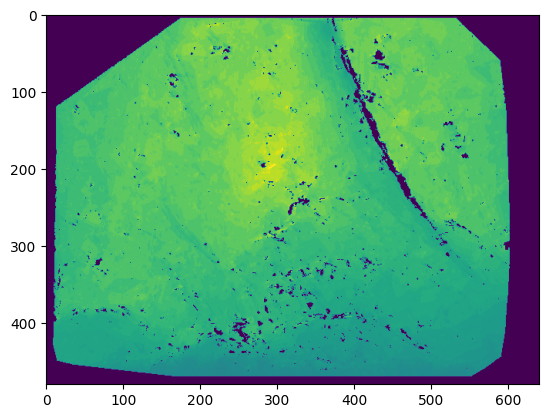

In [10]:
# path = './predicted_depths/depth000000.png'
# path = '/media/thesis_ssd/temp_test/depth000101.png'
path ='/media/thesis_ssd/data/Hamlyn/rectified01/depth02/0000000010.png'
img = mpimg.imread(path)
plt.imshow(img)

In [8]:
img.max()

0.49634546

In [39]:
import os
import datasets.scared_dataset
import torch
import numpy as np
def readlines(filename):
    """Read all the lines in a text file and return as a list
    """
    with open(filename, 'r') as f:
        lines = f.read().splitlines()
    return lines

data_path = "/media/thesis_ssd/data/SCARED" 
filenames = readlines(os.path.join('splits/endovis/test_files.txt'))
dataset = datasets.scared_dataset.SCAREDRAWDataset(data_path, filenames,
                                336, 336,
                                [0], 4, is_train=False)


dataloader = torch.utils.data.DataLoader(dataset, 2, shuffle=True, num_workers=1,
                        pin_memory=True, drop_last=False)

In [67]:
import torchvision.transforms as transforms
import random


colorjitter = transforms.ColorJitter(0.5,0.5,0.5,0.5)
gaussianblur = transforms.GaussianBlur(9)


def obtain_cutmix_box(img_size, p=0.5, size_min=0.02, size_max=0.1, ratio_1=0.3, ratio_2=1/0.3):
    mask = torch.zeros(img_size, img_size)
    if random.random() > p:
        return mask

    size = np.random.uniform(size_min, size_max) * img_size * img_size
    while True:
        ratio = np.random.uniform(ratio_1, ratio_2)
        cutmix_w = int(np.sqrt(size / ratio))
        cutmix_h = int(np.sqrt(size * ratio))
        x = np.random.randint(0, img_size)
        y = np.random.randint(0, img_size)

        if x + cutmix_w <= img_size and y + cutmix_h <= img_size:
            break

    mask[y:y + cutmix_h, x:x + cutmix_w] = 1

    return mask

def cutmix_augmentation(data,p = 0.5):
    IMG_SIZE = 336
    imgs = data[('color',0,0)].cuda()
    imgs_mixed = imgs.clone()
    for i in range(torch.floor_divide(len(imgs),2)):
        mask = 1-obtain_cutmix_box(IMG_SIZE,p = p).cuda()
        imgs_mixed[2*i] = mask*imgs[2*i]+(1-mask)*imgs[2*i+1]
        imgs_mixed[2*i+1] = mask*imgs[2*i+1]+(1-mask)*imgs[2*i]
    return imgs,imgs_mixed


In [41]:
for data in dataloader:
    break

In [64]:
img = data[('color',0,0)][0]
imgs,imgs_mixed = cutmix_augmentation(data,1)

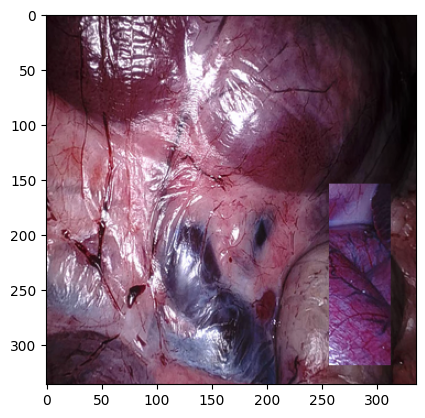

In [65]:
plt.imshow(imgs_mixed[0].permute(1,2,0).cpu())

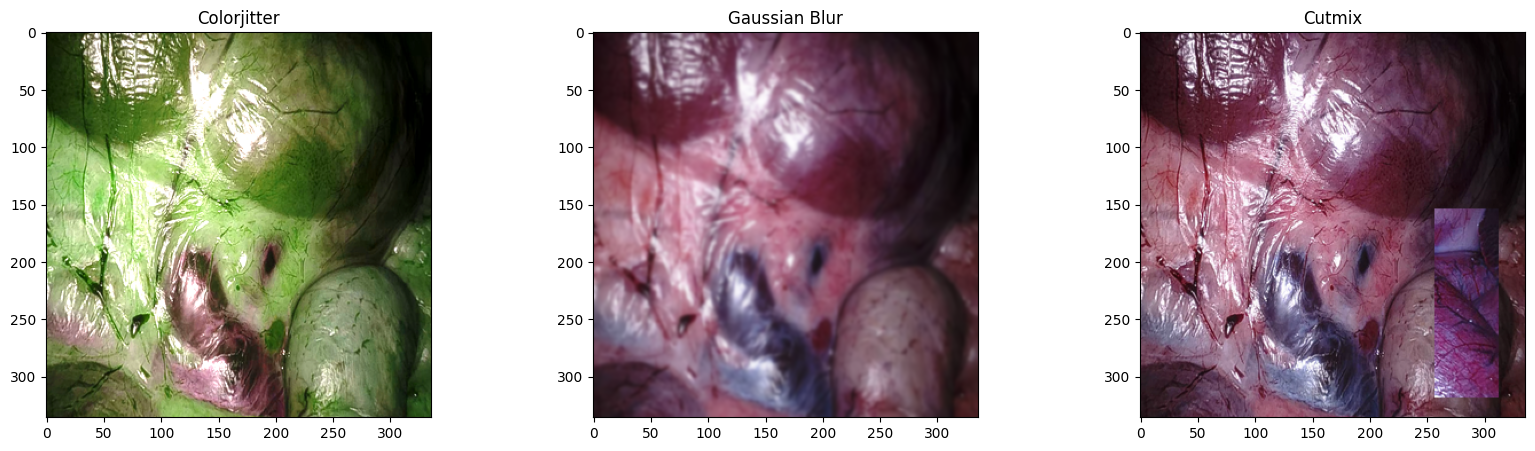

In [71]:
img_jittered = colorjitter(img)
img_blurred = gaussianblur(img)
img_mixed = imgs_mixed[0]
fig,ax = plt.subplots(1,3,figsize = (20,5))
ax[0].set_title('Colorjitter')
ax[0].imshow(img_jittered.permute(1,2,0))
ax[1].set_title('Gaussian Blur')
ax[1].imshow(img_blurred.permute(1,2,0))
ax[2].set_title('Cutmix')
ax[2].imshow(img_mixed.permute(1,2,0).cpu())

In [3]:
from models.SurgeDepth.dpt import SurgeDepth

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}
model = SurgeDepth(**model_configs['vitb']).cuda()
torch.no_grad()
state_dict = torch.load('models/SurgeDepth/SurgeDepth_V7.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [14]:
import torchvision
from PIL import Image
for id,data in enumerate(dataloader):
    input_color = data[("color", 0, 0)].cuda()
    # input_color = transform({'image': input_color})['image']
    
    input_color = torchvision.transforms.functional.normalize(input_color,mean=[0.46888983, 0.29536288, 0.28712815], std=[0.24689102 ,0.21034359, 0.21188641])
    pred_disp = model(input_color)
    pred_disp_normalized = (pred_disp-pred_disp.min())/(pred_disp.max()-pred_disp.min())*9+1
    pred_depth = 1/pred_disp_normalized
    
    pred_depth = (pred_depth-pred_depth.min())/(pred_depth.max()-pred_depth.min())*255
    pred_depth = pred_depth[0].cpu().detach().numpy()
    pred_depth = pred_depth.astype(np.uint8)
    # print(pred_depth.shape)
    # print(pred_depth.max())
    # plt.imsave('predicted_depths/depth{:06d}.png'.format(id),pred_depth,cmap='gray')
    im = Image.fromarray(pred_depth)
    im.save('predicted_depths/depth{:06d}.png'.format(id))
    # im = im.convert('Grayscale')
    # torchvision.utils.save_image(pred_depth[0],'predicted_depths/depth{:06d}.png'.format(id),format ='RGB')
    # fig,ax = plt.subplots(1,2)
    # ax[0].imshow(input_color[0].permute(1,2,0).cpu().detach().numpy())
    # ax[1].imshow(pred_disp[0].cpu().detach().numpy())
    # plt.show()
    if id>420:
        break
    


In [1]:
import imageio
im = imageio.imread("/media/thesis_ssd/code/Depth_evaluation/test.npy")

/tmp/ipykernel_549967/526957271.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread("/media/thesis_ssd/code/Depth_evaluation/test.npy")


ValueError: Could not find a backend to open `/media/thesis_ssd/code/Depth_evaluation/test.npy`` with iomode `ri`.

In [1]:
from datasets.hamlyn_dataset import HamlynDataset
import torchvision.transforms as tf
import torch

transforms = tf.Compose([tf.Resize((336,336),antialias = True),tf.ConvertImageDtype(torch.float32)])
transforms_depth = tf.Compose([tf.ToTensor()])

dataset = HamlynDataset(depth_dir='/media/thesis_ssd/data/Hamlyn/rectified01/depth01/',rgb_dir='/media/thesis_ssd/data/Hamlyn/rectified01/image01/',transform_img=transforms,transform_depth=transforms_depth)
dataset[0].keys()

dict_keys(['rgb', 'depth', 'id'])

In [9]:
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
lpips = LearnedPerceptualImagePatchSimilarity(net_type='alex')
# lpips(dataset[0]['depth'],dataset[0]['depth'])
depth = dataset[0]['depth']
depth_lpips = depth.unsqueeze(0)
depth_lpips = depth_lpips.repeat(1,3,1,1)

depth1 = dataset[1]['depth']
depth_lpips1 = depth1.unsqueeze(0)
depth_lpips1 = depth_lpips1.repeat(1,3,1,1)
lpips(depth_lpips,depth_lpips1)

/media/thesis_ssd/anaconda/envs/depth_eval_3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/thesis_ssd/anaconda/envs/depth_eval_3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor(0.7275, grad_fn=<SqueezeBackward0>)

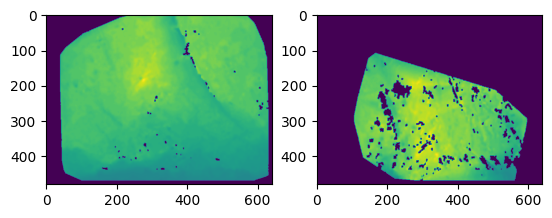

In [10]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2)
ax[0].imshow(depth_lpips[0,1,:,:])
ax[1].imshow(depth_lpips1[0,1,:,:])

In [26]:
from torchmetrics.image import StructuralSimilarityIndexMeasure
SSIM = StructuralSimilarityIndexMeasure()
loss = SSIM(depth.unsqueeze(0).double(),depth.unsqueeze(0).double())
loss

tensor(1.)